In [1]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [77]:
models   = ["ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
            "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"]
base_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
tol      = 5.0   # ±5 % for magnitude‐agreement
# ──────────────────────────────────────────────────────────────────────────────

# 1) Load seasonal‐means and compute Δ% per model, then convert to DataArray
rel_diff = {}
for model in models:
    boc_files = [
        os.path.join(base_dir, f"{model}_1x1grid/historical/aggregated_solar_power_seasons_{yr}.nc")
        for yr in range(1980, 2015)
    ]
    eoc_files = [
        os.path.join(base_dir, f"{model}_1x1grid/ssp585/aggregated_solar_power_seasons_{yr}.nc")
        for yr in range(2065, 2100)
    ]

    ds_boc = xr.concat(
        [xr.open_dataset(f).expand_dims(time=[yr]) for yr,f in zip(range(1980,2015), boc_files)],
        dim="time"
    )
    ds_eoc = xr.concat(
        [xr.open_dataset(f).expand_dims(time=[yr]) for yr,f in zip(range(2065,2100), eoc_files)],
        dim="time"
    )

    # compute the relative‐difference Dataset using medians
    ds_rel = (
        ds_eoc.median("time")
        - ds_boc.median("time")
    ) / ds_boc.median("time") * 100

    # convert to a single DataArray with a "season" dimension
    rel_diff[model] = ds_rel.to_array(dim="season")




In [78]:
SEASONS = {
    'Winter': [12, 1, 2],  # Maps to 'Winter' in the dataset
    'Spring': [3, 4, 5],   # Maps to 'Spring' in the dataset
    'Summer': [6, 7, 8],   # Maps to 'Summer' in the dataset
    'Autumn': [9, 10, 11]  # Maps to 'Autumn' in the dataset
}

In [79]:
import os
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box
from scipy.stats import shapiro, ttest_ind
from xarray.coding.times import CFDatetimeCoder

# -----------------------------------------------------------------------------
# 1) CONFIGURATION
# -----------------------------------------------------------------------------
base_dir     = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
models       = ["ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
                "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"]
EU27         = ['AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
                'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
                'SK','SI','ES','SE','CY']
extras       = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR',
                'UA','BY','MD','RU','XK']
region_codes = EU27 + extras

years_BOC = list(range(1980, 2015))
years_EOC = list(range(2065, 2100))

SEASONS = {
    'Winter': [12, 1, 2],  # Maps to 'Winter' in the dataset
    'Spring': [3, 4, 5],   # Maps to 'Spring' in the dataset
    'Summer': [6, 7, 8],   # Maps to 'Summer' in the dataset
    'Autumn': [9, 10, 11]  # Maps to 'Autumn' in the dataset
}

alpha = 0.05

# -----------------------------------------------------------------------------
# 2) BUILD 1°×1° GRID‐CELL POLYGONS
# -----------------------------------------------------------------------------
# pick one file just to get lats/lons
sample_fp = os.path.join(
    base_dir,
    f"{models[0]}_1x1grid/historical/aggregated_solar_power_seasons_{years_BOC[0]}.nc"
)
ds0  = xr.open_dataset(sample_fp, decode_times=CFDatetimeCoder(use_cftime=True))
lats = ds0['lat'].values
lons = ds0['lon'].values
ds0.close()

dlat = float(np.diff(lats).mean())
dlon = float(np.diff(lons).mean())

cells = [
    {'lon': float(lon), 'lat': float(lat),
     'geometry': box(lon-dlon/2, lat-dlat/2, lon+dlon/2, lat+dlat/2)}
    for lat in lats for lon in lons
]
gdf_cells = gpd.GeoDataFrame(cells, crs="EPSG:4326")

# -----------------------------------------------------------------------------
# 3) LOAD & FIX COUNTRY POLYGONS (EU27 + EXTRAS)
# -----------------------------------------------------------------------------
ne50  = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France', 'ISO_A2']                       = 'FR'
world.loc[world.NAME_LONG=='Norway', 'ISO_A2']                       = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov', na=False), 'ISO_A2'] = 'XK'

eu_plus = world[world.ISO_A2.isin(region_codes)][['ISO_A2','geometry']].copy()

# -----------------------------------------------------------------------------
# 4) INTERSECT & COMPUTE GRID‐CELL WEIGHTS
# -----------------------------------------------------------------------------
proj_crs = "EPSG:3035"
cells_pa = gdf_cells.to_crs(proj_crs)
cells_pa['cell_area'] = cells_pa.geometry.area
eu_pa     = eu_plus.to_crs(proj_crs)

inter = gpd.overlay(cells_pa, eu_pa, how='intersection')
inter['weight'] = inter.geometry.area / inter['cell_area']
inter = inter[['lon','lat','ISO_A2','weight']].reset_index(drop=True)

# -----------------------------------------------------------------------------
# 5) HELPER: SUM‐WEIGHTED AGGREGATION TO COUNTRY
# -----------------------------------------------------------------------------
def country_agg(da2d, inter):
    df = da2d.to_dataframe(name='P').reset_index()  # lat, lon, P
    df = df.merge(inter, on=['lon','lat'], how='inner')
    df['c'] = df['P'] * df['weight']
    return df.groupby('ISO_A2')['c'].sum()

In [116]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import shapiro, ttest_ind

# ** your pre‐computed `inter` GeoDataFrame and `country_agg()` helper must already exist **
# ** your SEASONS dict and region_codes list must also already exist **

models   = ["ACCESS-CM2","CanESM5","CMCC-CM2-SR5","CMCC-ESM2",
            "HadGEM3-GC31-LL","HadGEM3-GC31-MM","MRI-ESM2-0"]
base_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
alpha    = 0.05

records = []
yrs_boc= list(range(1980, 2015))
yrs_eoc= list(range(2065, 2100))

for model in models:
    boc_files = [
        os.path.join(base_dir, f"{model}_1x1grid/historical/aggregated_solar_power_seasons_{yr}.nc")
        for yr in range(1980, 2015)
    ]
    eoc_files = [
        os.path.join(base_dir, f"{model}_1x1grid/ssp585/aggregated_solar_power_seasons_{yr}.nc")
        for yr in range(2065, 2100)
    ]

    ds_boc = xr.concat(
        [xr.open_dataset(f).expand_dims(time=[yr]) for yr,f in zip(range(1980,2015), boc_files)],
        dim="time"
    )
    ds_eoc = xr.concat(
        [xr.open_dataset(f).expand_dims(time=[yr]) for yr,f in zip(range(2065,2100), eoc_files)],
        dim="time"
    )
    # 3) now loop over seasons
    for season in SEASONS.keys():  # 'DJF','MAM','JJA','SON'
        boc_da = ds_boc[season]  # dims (time, y, x)
        eoc_da = ds_eoc[season]

        # 4) build year→country dicts
        boc_dict = {
            int(t): country_agg(boc_da.sel(time=t), inter).to_dict()
            for t in boc_da.time.values
        }
        eoc_dict = {
            int(t): country_agg(eoc_da.sel(time=t), inter).to_dict()
            for t in eoc_da.time.values
        }

        # 5) only keep years both have

        for iso in region_codes:
            # 6) pull out paired series
            b = np.array([boc_dict[y].get(iso, np.nan) for y in yrs_boc])
            e = np.array([eoc_dict[y].get(iso, np.nan) for y in yrs_eoc])

            # 7) drop any missing
            mask = (~np.isnan(b)) & (~np.isnan(e))
            b, e = b[mask], e[mask]

            # need ≥3 years to run the tests
            if len(b) < 3:
                continue

            # 8) stats
            p_sb = shapiro(b)[1]
            p_se = shapiro(e)[1]
            p_tt = ttest_ind(e, b, equal_var=False)[1]

            # 9) medians & rel‐change
            m_b = np.median(b)
            m_e = np.median(e)
            rel = (m_e - m_b)/m_b*100 if m_b != 0 else np.nan

            records.append({
                'model':         model,
                'ISO_A2':        iso,
                'season':        season,
                'p_shapiro_BOC': p_sb,
                'p_shapiro_EOC': p_se,
                'p_ttest':       p_tt,
                'median_BOC':    m_b,
                'median_EOC':    m_e,
                'rel_change_%':  rel,
                'signif_ttest':  (p_tt < alpha)
            })

# finally, dump to CSV
dfm = pd.DataFrame.from_records(records)
print("rows saved:", len(dfm))
dfm.to_csv('solar_model_stats_per_season.csv', index=False)


rows saved: 1148


In [112]:
dfm = pd.DataFrame.from_records(records)
dfm.to_csv('solar_model_stats_per_season.csv', index=False)



In [117]:
# -----------------------------------------------------------------------------
# 7) SUMMARY PER COUNTRY & SEASON
# -----------------------------------------------------------------------------
# strip stray whitespace & group
dfm.columns = dfm.columns.str.strip()
summary = (
    dfm
    .groupby(['ISO_A2','season'])
    .apply(lambda g: pd.Series({
        'n_models_tested':      len(g),
        'n_models_significant': int(g['signif_ttest'].sum()),
        'median_rel_change_sig': float(
            np.median(g.loc[g['signif_ttest'], 'rel_change_%'])
        )
    }))
    .reset_index()
)

# save and print
summary.to_csv('solar_stats_seasonal_summary.csv', index=False)
print("Seasonal summary per country:\n", summary)


Seasonal summary per country:
     ISO_A2  season  n_models_tested  n_models_significant  \
0       AL  Autumn              7.0                   7.0   
1       AL  Spring              7.0                   6.0   
2       AL  Summer              7.0                   5.0   
3       AL  Winter              7.0                   6.0   
4       AT  Autumn              7.0                   7.0   
..     ...     ...              ...                   ...   
159     UA  Winter              7.0                   7.0   
160     XK  Autumn              7.0                   7.0   
161     XK  Spring              7.0                   6.0   
162     XK  Summer              7.0                   4.0   
163     XK  Winter              7.0                   7.0   

     median_rel_change_sig  
0                14.325245  
1                12.967088  
2                -2.916995  
3                21.853060  
4                15.411743  
..                     ...  
159             -17.701562  
160 

/tmp/ipykernel_117494/1300384371.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


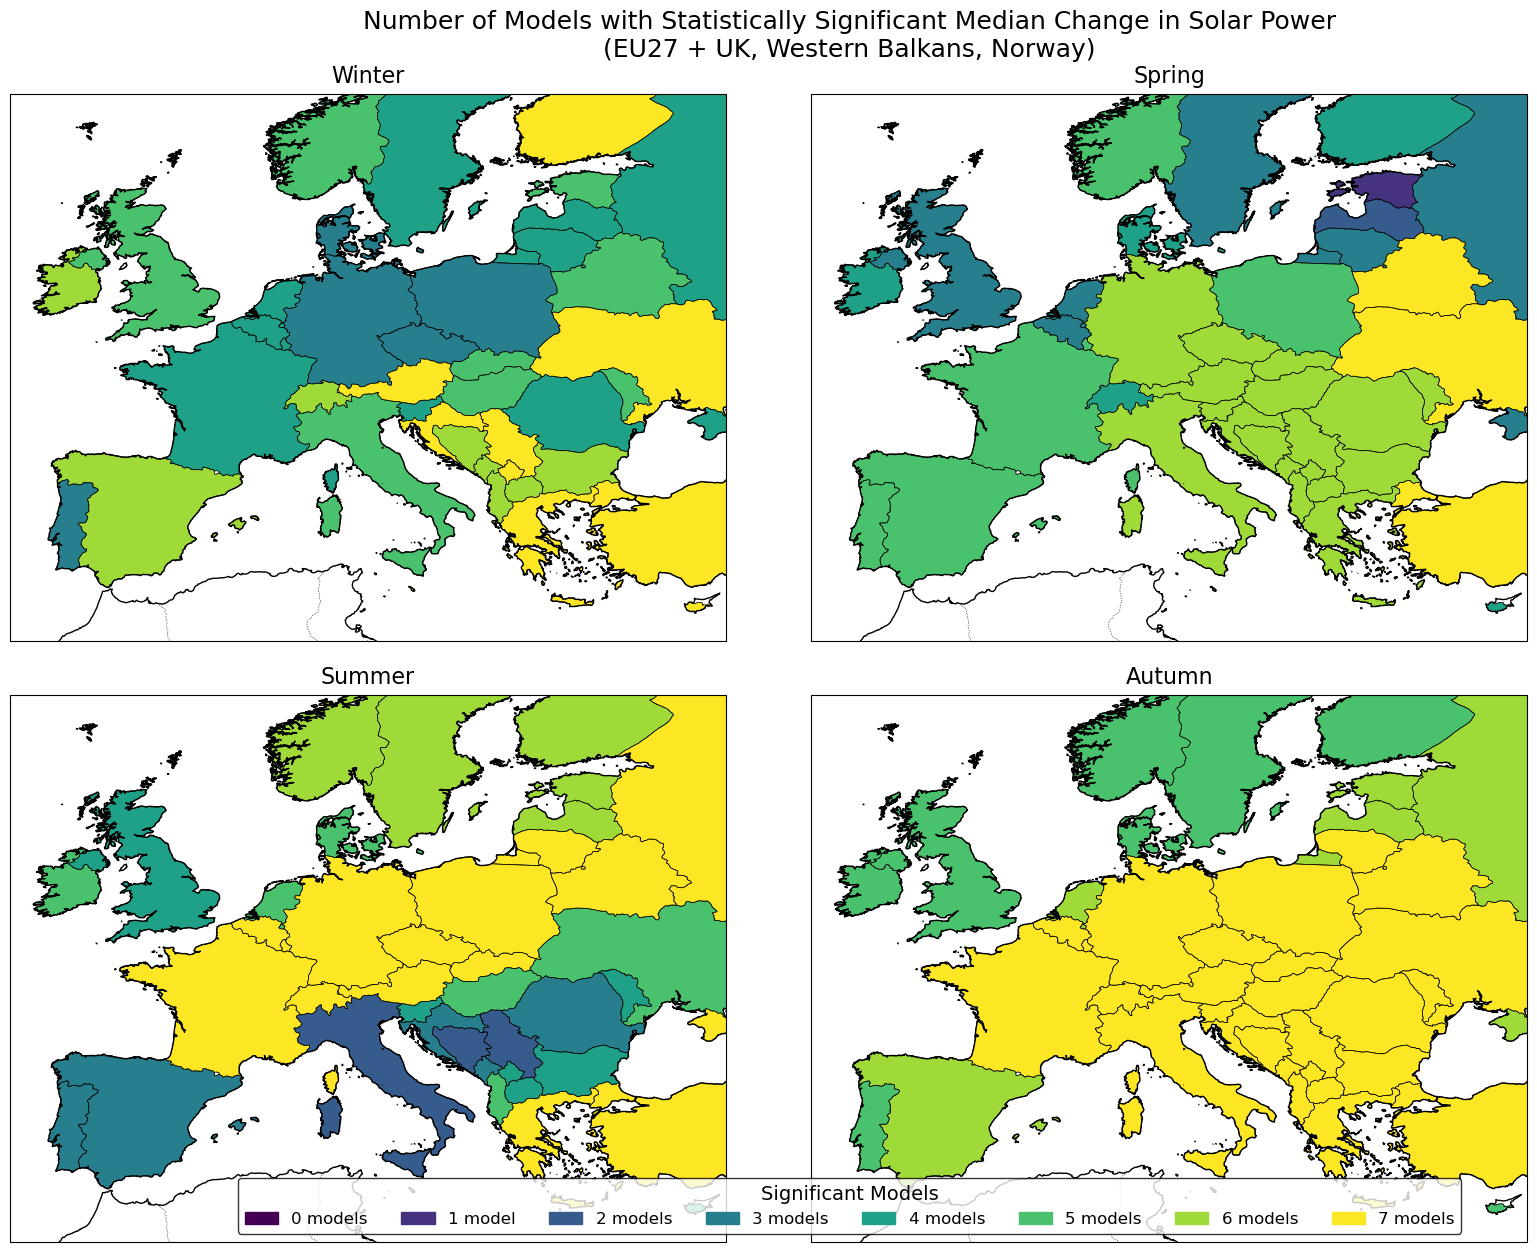

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl

# 1) Load the seasonal summary
summary = pd.read_csv('solar_stats_seasonal_summary.csv')

# 2) Regions
EU27 = [
    'AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
    'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
    'SK','SI','ES','SE','CY'
]
extras = [
    'GB','NO','BA','ME','RS','AL','MK','CH','IS','TR',
    'UA','BY','MD','RU','XK'
]
region_codes = EU27 + extras

# 3) Country geometries
ne50 = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France',  'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Norway',  'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov', na=False), 'ISO_A2'] = 'XK'
eu = world[world.ISO_A2.isin(region_codes)][['ISO_A2','geometry']].copy()

# 4) Prepare colormap
maxm = int(summary['n_models_significant'].max())
cmap = plt.get_cmap('Greens', maxm+1)
norm = mpl.colors.BoundaryNorm(np.arange(maxm+2)-0.5, maxm+1)

# 5) Seasons and panel setup (no constrained_layout)
seasons = ['Winter','Spring','Summer','Autumn']
fig, axes = plt.subplots(
    2, 2,
    figsize=(18,14),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=False
)

# 6) Plot each season
for ax, season in zip(axes.flat, seasons):
    df_seas = summary[summary['season'] == season]
    gdf = eu.merge(
        df_seas[['ISO_A2','n_models_significant']],
        on='ISO_A2',
        how='left'
    )
    gdf['n_models_significant'] = gdf['n_models_significant'].fillna(0).astype(int)

    gdf.plot(
        column='n_models_significant',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax,
        missing_kwds={'color':'lightgrey'}
    )
    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12, 35, 33, 64], crs=ccrs.PlateCarree())
    ax.set_title(season, fontsize=16, pad=8)

# 7) Carve out margins for title & legend
fig.subplots_adjust(
    left=0.03, right=0.88,
    top=0.90, bottom=0.08,
    wspace=0.10, hspace=0.10
)

# 8) Shared legend below (optional repositioning)
patches = [
    mpatches.Patch(color=cmap(i), label=f"{i} {'model' if i==1 else 'models'}")
    for i in range(maxm+1)
]
fig.legend(
    handles=patches,
    title="Significant Models",
    loc='lower center',
    ncol=8,
    fontsize=12,
    title_fontsize=14,
    frameon=True,
    edgecolor='black',
    bbox_to_anchor=(0.5, 0.08)
)

# 9) Suptitle in the top margin
fig.suptitle(
    "Number of Models with Statistically Significant Median Change in Solar Power\n"
    "(EU27 + UK, Western Balkans, Norway)",
    fontsize=18,
    y=0.96
)

plt.show()


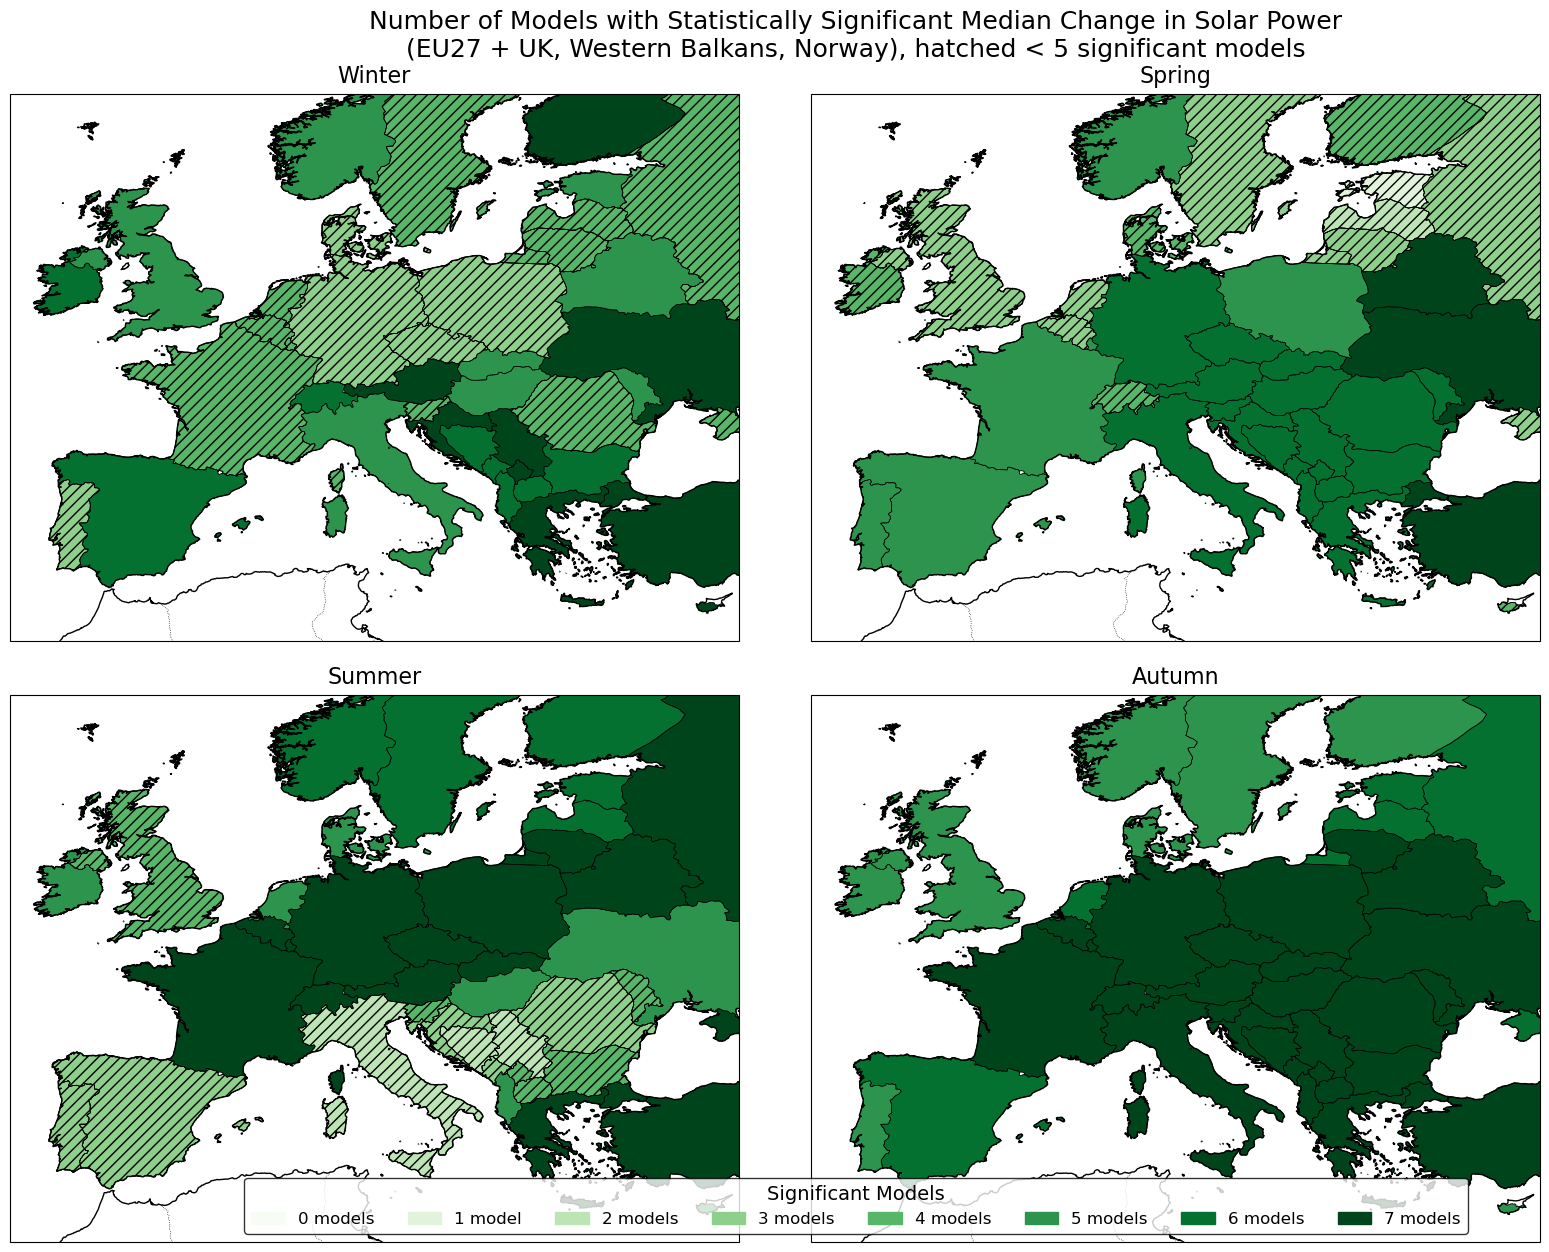

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl

# 1) Load the seasonal summary
summary = pd.read_csv('solar_stats_seasonal_summary.csv')

# 2) Regions
EU27 = [
    'AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
    'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
    'SK','SI','ES','SE','CY'
]
extras = [
    'GB','NO','BA','ME','RS','AL','MK','CH','IS','TR',
    'UA','BY','MD','RU','XK'
]
region_codes = EU27 + extras

# 3) Country geometries
ne50 = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
world = gpd.read_file(ne50).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France',  'ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Norway',  'ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov', na=False), 'ISO_A2'] = 'XK'
eu = world[world.ISO_A2.isin(region_codes)][['ISO_A2','geometry']].copy()

# 4) Prepare colormap
maxm = int(summary['n_models_significant'].max())
from matplotlib.colors import LinearSegmentedColormap
# Create a lighter version of RdBu_r

cmap = plt.get_cmap('Greens', maxm+1)
norm = mpl.colors.BoundaryNorm(np.arange(maxm+2)-0.5, maxm+1)

# 5) Seasons and panel setup (no constrained_layout)
seasons = ['Winter','Spring','Summer','Autumn']
fig, axes = plt.subplots(
    2, 2,
    figsize=(18, 14),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=False
)

# 6) Plot each season
for ax, season in zip(axes.flat, seasons):
    df_seas = summary[summary['season'] == season]
    gdf = eu.merge(
        df_seas[['ISO_A2','n_models_significant']],
        on='ISO_A2',
        how='left'
    )
    gdf['n_models_significant'] = gdf['n_models_significant'].fillna(0).astype(int)

    # Plot the main map
    gdf.plot(
        column='n_models_significant',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax,
        missing_kwds={'color':'lightgrey'}
    )

    # Apply hatching for countries with fewer than 5 significant models
    low = gdf[gdf['n_models_significant'] < 5]
    low.plot(
        ax=ax,
        facecolor="none",       # Don’t fill—let the choropleth show through
        edgecolor="black",      # Draw country borders so hatch is clipped
        hatch='///',            # Or 'xxx', '...', whichever you like
        linewidth=0.5,          # Match the border width
        zorder=3
    )

    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_extent([-12, 35, 33, 64], crs=ccrs.PlateCarree())
    ax.set_aspect('auto')  # Allow the aspect ratio to adjust automatically
    ax.set_title(season, fontsize=16, pad=8)

# 7) Carve out margins for title & legend
fig.subplots_adjust(
    left=0.03, right=0.88,
    top=0.90, bottom=0.08,
    wspace=0.10, hspace=0.10
)

# 8) Shared legend below (optional repositioning)
patches = [
    mpatches.Patch(color=cmap(i), label=f"{i} {'model' if i==1 else 'models'}")
    for i in range(maxm+1)
]
fig.legend(
    handles=patches,
    title="Significant Models",
    loc='lower center',
    ncol=8,
    fontsize=12,
    title_fontsize=14,
    frameon=True,
    edgecolor='black',
    bbox_to_anchor=(0.5, 0.08)
)

# 9) Suptitle in the top margin
fig.suptitle(
    "Number of Models with Statistically Significant Median Change in Solar Power\n"
    "(EU27 + UK, Western Balkans, Norway), hatched < 5 significant models",
    fontsize=18,
    y=0.96
)

plt.show()

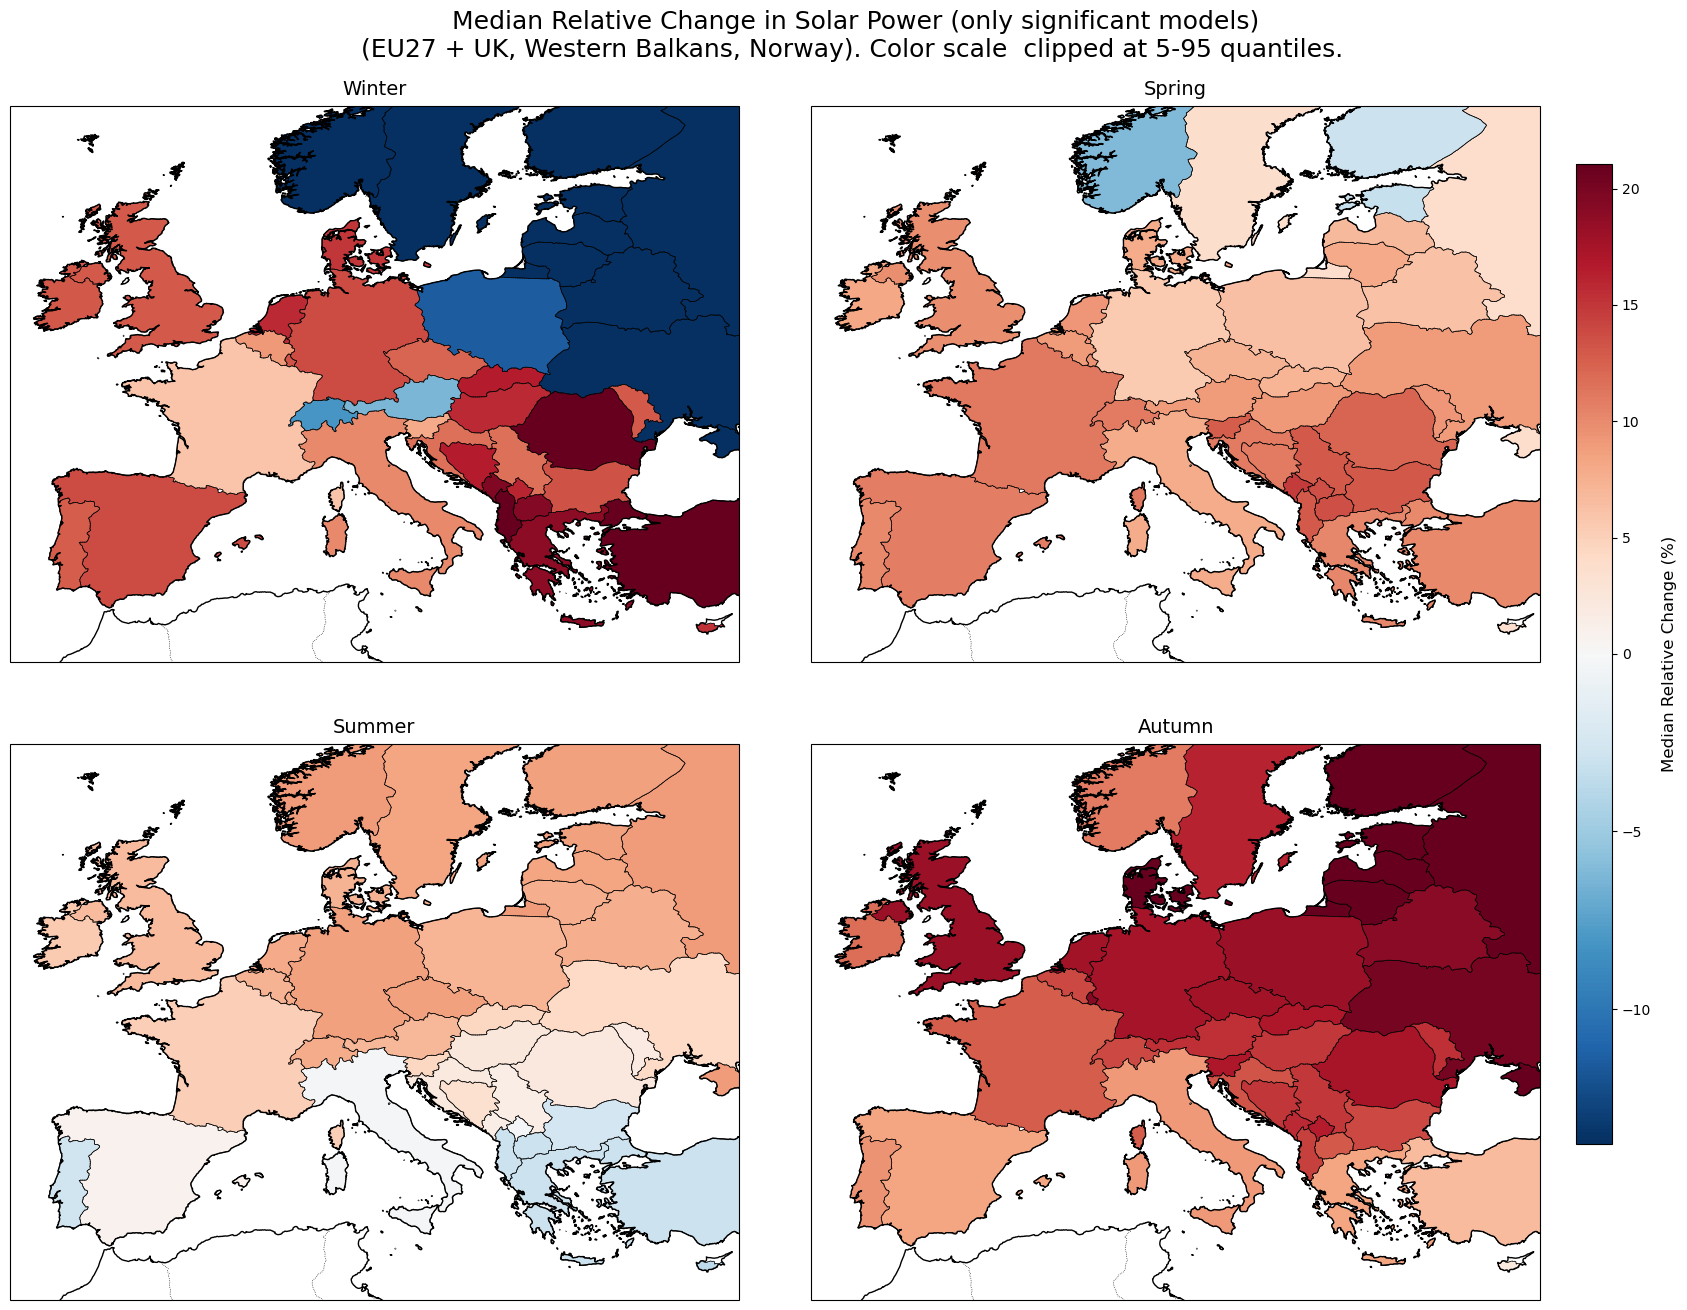

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import matplotlib as mpl

# 1) Load your seasonal summary (with a 'season' column)
summary = pd.read_csv('solar_stats_seasonal_summary.csv')

# 2) Region codes & Natural Earth
EU27 = ['AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
        'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
        'SK','SI','ES','SE','CY']
extras = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR','UA','BY','MD','RU','XK']
codes = EU27 + extras

world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France','ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Norway','ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov', na=False),'ISO_A2'] = 'XK'

eu_base = world[world.ISO_A2.isin(codes)][['ISO_A2','geometry']].copy()

# 3) Colour scale
# compute the 1% and 99% quantiles
vmin = summary['median_rel_change_sig'].quantile(0.05)
vmax = summary['median_rel_change_sig'].quantile(0.95)
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)


cmap = plt.get_cmap('RdBu_r')

# 4) Figure + 2×2 axes (no constrained_layout)
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    2, 2,
    figsize=(18,14),
    subplot_kw={'projection':proj}
)

# 5) Plot each season
seasons = ['Winter','Spring','Summer','Autumn']
for ax, season in zip(axes.flat, seasons):
    df_seas = summary[summary['season']==season]
    eu = eu_base.merge(df_seas[['ISO_A2','median_rel_change_sig']],
                       on='ISO_A2', how='left')
    eu['median_rel_change_sig'] = eu['median_rel_change_sig'].fillna(0)

    eu.plot(
        column='median_rel_change_sig',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax, legend=False,
        missing_kwds={'color':'lightgrey'}
    )
    ax.set_title(season, fontsize=14, pad=8)
    ax.set_extent([-12,35,33,64], crs=ccrs.PlateCarree())
    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# 6) Adjust subplots to make room at top & right
fig.subplots_adjust(
    left=0.03, right=0.88,
    top=0.90, bottom=0.03,
    wspace=0.1, hspace=0.1
)

# 7) Shared colourbar out to the right
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Median Relative Change (%)', fontsize=12, labelpad=8)
cbar.ax.tick_params(labelsize=10)

# 8) Suptitle up in the margin
fig.suptitle(
    'Median Relative Change in Solar Power (only significant models)\n'
    '(EU27 + UK, Western Balkans, Norway). Color scale  clipped at 5-95 quantiles. ',
    fontsize=18,
    y=0.96  # push it up into the top margin
)

plt.show()


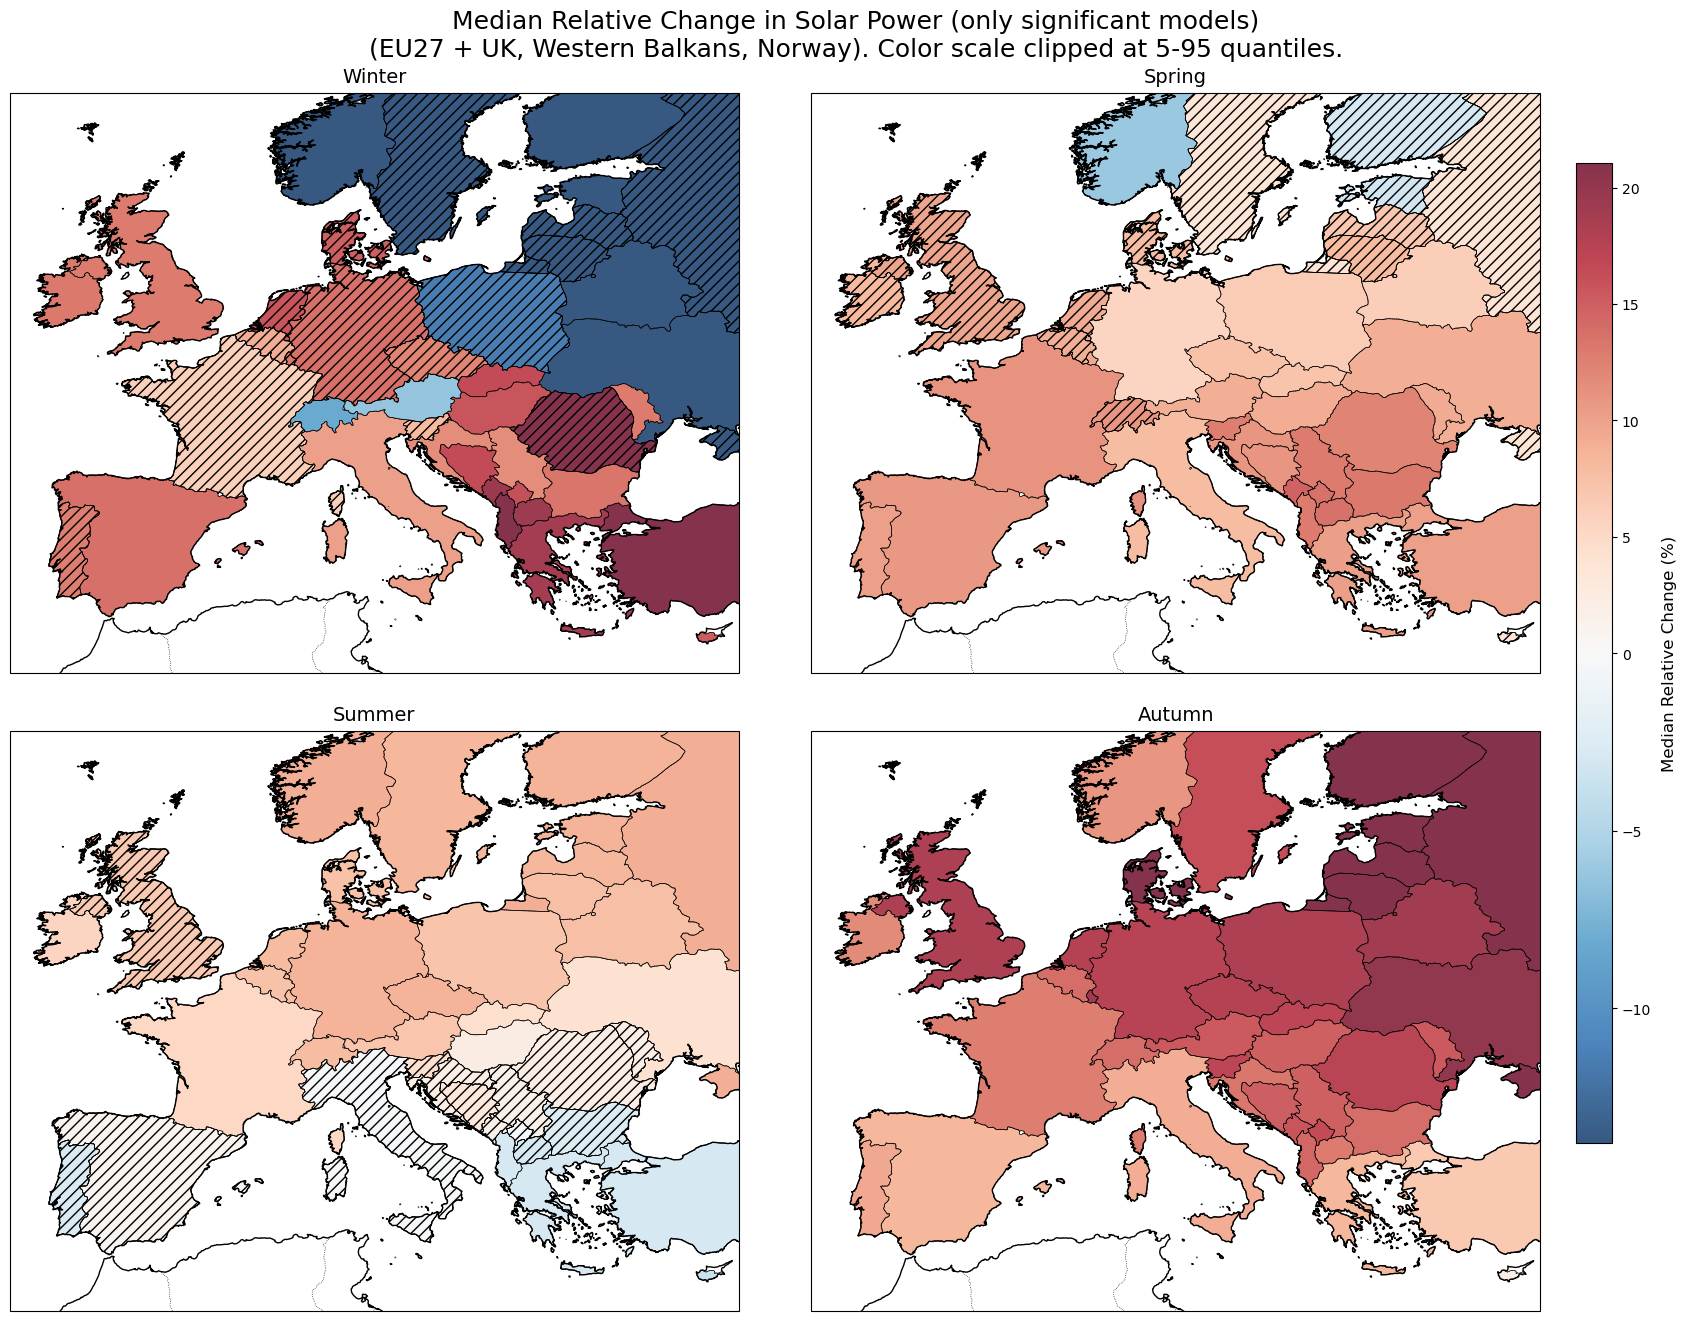

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import matplotlib as mpl

# 1) Load your seasonal summary (with a 'season' column)
summary = pd.read_csv('solar_stats_seasonal_summary.csv')

# 2) Region codes & Natural Earth
EU27 = ['AT','BE','BG','HR','CZ','DK','EE','FI','FR','DE','GR',
        'HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO',
        'SK','SI','ES','SE','CY']
extras = ['GB','NO','BA','ME','RS','AL','MK','CH','IS','TR','UA','BY','MD','RU','XK']
codes = EU27 + extras

world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
).to_crs("EPSG:4326")
world.loc[world.NAME_LONG=='France','ISO_A2'] = 'FR'
world.loc[world.NAME_LONG=='Norway','ISO_A2'] = 'NO'
world.loc[world.NAME_LONG.str.contains('Kosov', na=False),'ISO_A2'] = 'XK'

eu_base = world[world.ISO_A2.isin(codes)][['ISO_A2','geometry']].copy()

# 3) Colour scale
vmin = summary['median_rel_change_sig'].quantile(0.05)
vmax = summary['median_rel_change_sig'].quantile(0.95)
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

from matplotlib.colors import LinearSegmentedColormap

# Create a lighter version of RdBu_r
original_cmap = plt.get_cmap('RdBu_r')
colors = original_cmap(np.linspace(0, 1, 256))
lighter_colors = (1 - 0.2) * colors + 0.2  # Blend with white (adjust 0.5 for more/less lightness)
lighter_cmap = LinearSegmentedColormap.from_list('LighterRdBu_r', lighter_colors)
cmap = lighter_cmap

# 4) Figure + 2×2 axes (no constrained_layout)
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    2, 2,
    figsize=(18, 14),
    subplot_kw={'projection': proj}
)

# 5) Plot each season
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
for ax, season in zip(axes.flat, seasons):
    df_seas = summary[summary['season'] == season]

    eu_sign= eu_base.merge(
        df_seas[['ISO_A2', 'n_models_significant']],
        on='ISO_A2', how='left'
    )
    eu_sign['n_models_significant'] = eu_sign['n_models_significant'].fillna(0).astype(int)
    eu = eu_base.merge(df_seas[['ISO_A2', 'median_rel_change_sig']],
                       on='ISO_A2', how='left')
    eu['median_rel_change_sig'] = eu['median_rel_change_sig'].fillna(0)

    # Plot the main map
    eu.plot(
        column='median_rel_change_sig',
        cmap=cmap, norm=norm,
        linewidth=0.5, edgecolor='black',
        ax=ax, legend=False,
        missing_kwds={'color': 'lightgrey'}
    )

    # Apply hatching for countries with fewer than 5 significant models
    low = eu_sign[eu_sign['n_models_significant'] < 5]
    low.plot(
        ax=ax,
        facecolor="none",       # Don’t fill—let the choropleth show through
        edgecolor="black",      # Draw country borders so hatch is clipped
        hatch='///',            # Or 'xxx', '...', whichever you like
        linewidth=0.5,          # Match the border width
        zorder=3
    )

    ax.set_title(season, fontsize=14, pad=8)
    ax.set_extent([-12, 35, 33, 64], crs=ccrs.PlateCarree())
    ax.coastlines('10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_aspect('auto')  # Allow the aspect ratio to adjust automatically

# 6) Adjust subplots to make room at top & right
fig.subplots_adjust(
    left=0.03, right=0.88,
    top=0.90, bottom=0.03,
    wspace=0.1, hspace=0.1
)

# 7) Shared colourbar out to the right
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Median Relative Change (%)', fontsize=12, labelpad=8)
cbar.ax.tick_params(labelsize=10)

# 8) Suptitle up in the margin
fig.suptitle(
    'Median Relative Change in Solar Power (only significant models)\n'
    '(EU27 + UK, Western Balkans, Norway). Color scale clipped at 5-95 quantiles.',
    fontsize=18,
    y=0.96  # push it up into the top margin
)

plt.show()